In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 11.3 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 12.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 12.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 [seaborn]2/14 [matplotlib]n]


In [14]:
# ======================================
# 1. Import Required Libraries
# ======================================
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("Libraries imported successfully!")


Libraries imported successfully!


In [15]:
# ============================================================
# 2. Data Loading
# ============================================================

def load_data():
    """Load all necessary preprocessed data"""
    print("Loading data...")

    # --- Load precomputed CNN image features ---
    image_features = np.load('../data/image_features.npy')
    print(f"✅ Image features loaded! Shape: {image_features.shape}")

    # --- Load train, validation, and test image lists ---
    with open('../data/train.json', 'r') as f:
        train_images = json.load(f)
    with open('../data/val.json', 'r') as f:
        val_images = json.load(f)
    with open('../data/test.json', 'r') as f:
        test_images = json.load(f)

    # Merge all image lists
    all_images = train_images + val_images + test_images
    print(f"🖼️ Total number of images: {len(all_images)}")

    # --- Load captions data ---
    with open('../data/captions_tokens.json', 'r') as f:
        captions_data = json.load(f)

    # --- Load vocabulary mapping (index-to-word) ---
    with open('../data/idx_to_word.json', 'r') as f:
        idx_to_word = json.load(f)

    print("✅ All JSON files loaded successfully!")

    return image_features, all_images, captions_data, idx_to_word


# --- Execute the data loading function ---
image_features, all_images, captions_data, idx_to_word = load_data()



Loading data...
✅ Image features loaded! Shape: (10921, 2048)
🖼️ Total number of images: 10921
✅ All JSON files loaded successfully!


In [16]:
# ======================================
# 3. Scene Label Extraction
# ======================================
def extract_scene_labels(image_list, captions_data, idx_to_word):
    """Extract scene labels from image captions using keyword matching"""
    print("Extracting scene labels...")
    
    scene_keywords = {
        'airport': ['airport', 'plane', 'runway', 'terminal'],
        'bareland': ['bare', 'land', 'ground', 'soil'],
        'beach': ['beach', 'sand', 'sea', 'ocean', 'shore'],
        'bridge': ['bridge', 'river', 'crossing'],
        'center': ['center', 'downtown', 'city'],
        'church': ['church', 'temple', 'religious'],
        'forest': ['forest', 'tree', 'woodland'],
        'industrial': ['industrial', 'factory', 'manufacturing'],
        'park': ['park', 'green', 'recreation'],
        'river': ['river', 'stream', 'water'],
        'school': ['school', 'education', 'campus'],
        'stadium': ['stadium', 'sports', 'arena'],
        'mountain': ['mountain', 'hill', 'peak']
    }
    
    scene_labels = []
    valid_indices = []

    for i, img_name in enumerate(image_list):
        if img_name in captions_data:
            descriptions = captions_data[img_name]
            scene_scores = {}
            for scene, keywords in scene_keywords.items():
                score = 0
                for caption in descriptions:
                    for token in caption:
                        if str(token) in idx_to_word:
                            word = idx_to_word[str(token)].lower()
                            if word in keywords:
                                score += 1
                scene_scores[scene] = score
            
            if max(scene_scores.values()) > 0:
                predicted_scene = max(scene_scores, key=scene_scores.get)
                scene_labels.append(predicted_scene)
                valid_indices.append(i)
    
    print(f"Extracted {len(scene_labels)} scene labels across {len(set(scene_labels))} categories.")
    return scene_labels, valid_indices

all_labels, all_valid_indices = extract_scene_labels(all_images, captions_data, idx_to_word)


Extracting scene labels...
Extracted 8825 scene labels across 13 categories.


Feature shape: (8825, 2048), Labels: 8825


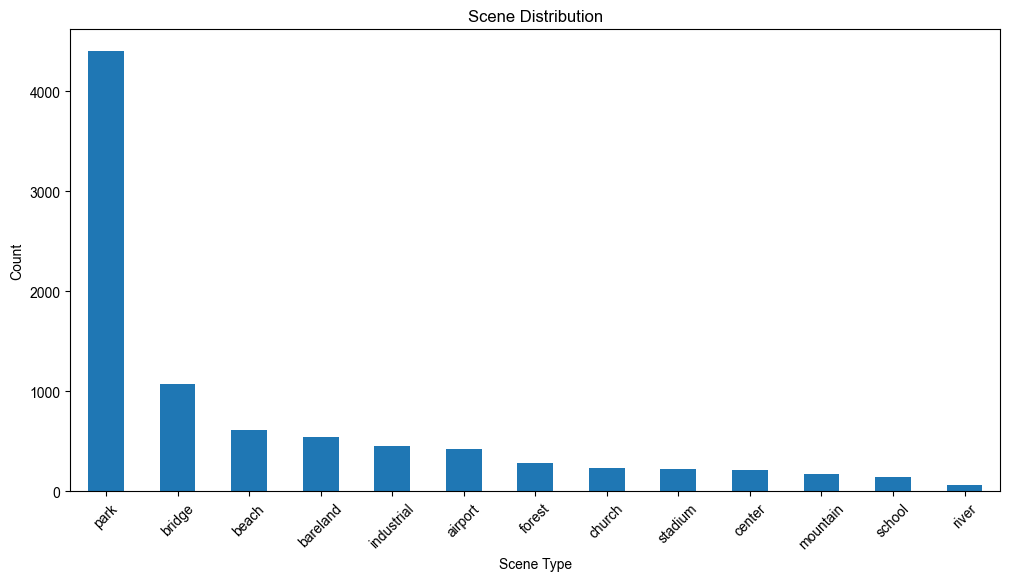

Training: 5295, Validation: 1765, Test: 1765


In [17]:
# ======================================
# 4. Data Preparation and Splitting
# ======================================
X_all = image_features[all_valid_indices]
y_all = all_labels

print(f"Feature shape: {X_all.shape}, Labels: {len(y_all)}")

scene_counts = pd.Series(y_all).value_counts()
plt.figure(figsize=(12,6))
scene_counts.plot(kind='bar')
plt.title("Scene Distribution")
plt.xlabel("Scene Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

print(f"Training: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")


In [18]:
# ======================================
# 5. Feature Scaling
# ======================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete.")
print(f"Scaled training feature range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")


Feature scaling complete.
Scaled training feature range: [-2.131, 21.121]


In [19]:
# ======================================
# 6. Train and Evaluate KNN
# ======================================
def train_and_evaluate_knn(X_train, X_test, y_train, y_test, n_neighbors=5, weights='uniform', metric='minkowski'):
    print(f"Training KNN classifier (n_neighbors={n_neighbors}, weights={weights}, metric={metric})...")
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5)

    print("\n=== Model Evaluation Results ===")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    return knn, y_pred, accuracy, cv_scores

knn_model, y_pred_knn, acc_knn, cv_knn = train_and_evaluate_knn(
    X_train_scaled, X_test_scaled, y_train, y_test, n_neighbors=5)


Training KNN classifier (n_neighbors=5, weights=uniform, metric=minkowski)...

=== Model Evaluation Results ===
Test Accuracy: 0.5462
CV Accuracy: 0.5656 (+/- 0.0303)



=== Classification Report ===
              precision    recall  f1-score   support

     airport       0.49      0.48      0.49        85
    bareland       0.13      0.08      0.10       108
       beach       0.51      0.48      0.49       123
      bridge       0.46      0.42      0.44       214
      center       0.26      0.25      0.26        44
      church       0.40      0.50      0.44        46
      forest       0.31      0.20      0.24        56
  industrial       0.55      0.37      0.44        90
    mountain       0.10      0.06      0.07        34
        park       0.64      0.76      0.70       880
       river       0.00      0.00      0.00        12
      school       0.10      0.04      0.05        28
     stadium       0.38      0.33      0.36        45

    accuracy                           0.55      1765
   macro avg       0.33      0.31      0.31      1765
weighted avg       0.51      0.55      0.52      1765



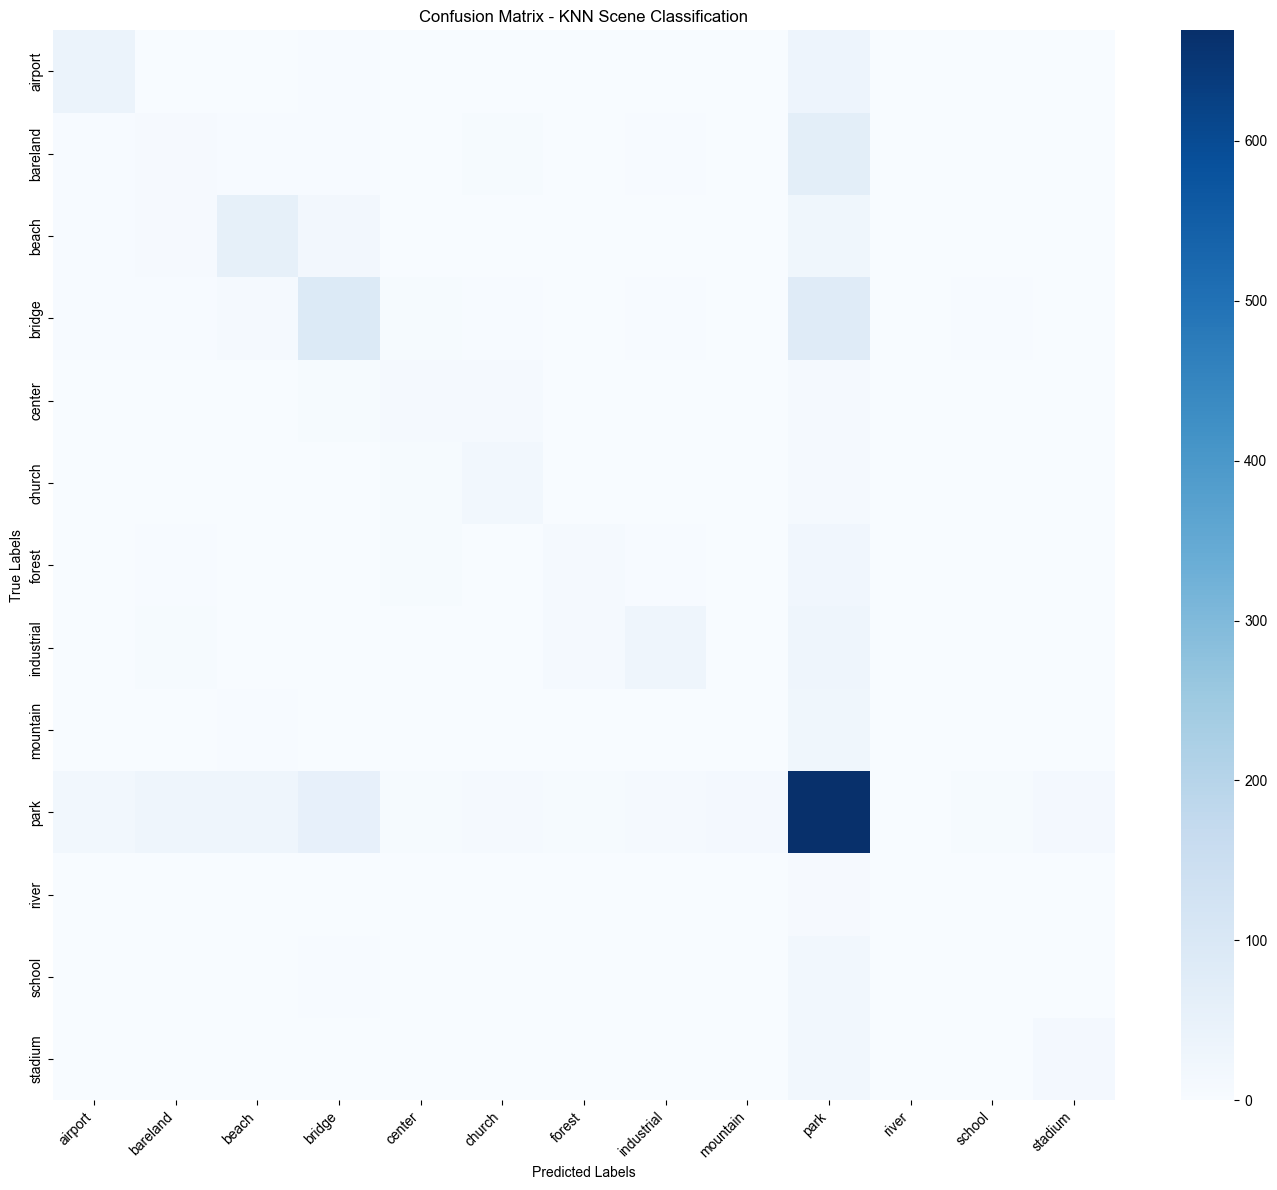

In [20]:
# ======================================
# 7. Performance Report and Confusion Matrix
# ======================================
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
unique_labels = sorted(set(y_test))

plt.figure(figsize=(14,12))
sns.heatmap(cm_knn, annot=False, cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title("Confusion Matrix - KNN Scene Classification")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [21]:
# ======================================
# 8. Quick Hyperparameter Testing
# ======================================
print("\n=== Quick Hyperparameter Testing ===")

test_params = [
    {'n_neighbors': 3, 'weights': 'uniform'},
    {'n_neighbors': 5, 'weights': 'uniform'},
    {'n_neighbors': 7, 'weights': 'uniform'},
    {'n_neighbors': 5, 'weights': 'distance'},
]

best_score = 0
best_params = None
best_model = None

for i, params in enumerate(test_params):
    print(f"\nTesting combination {i+1}: {params}")
    knn_temp = KNeighborsClassifier(**params)
    cv_scores = cross_val_score(knn_temp, X_train_scaled, y_train, cv=3)
    mean_score = cv_scores.mean()
    print(f"CV Score: {mean_score:.4f}")

    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        best_model = knn_temp

print(f"\nBest Quick Test: {best_params}, Score: {best_score:.4f}")



=== Quick Hyperparameter Testing ===

Testing combination 1: {'n_neighbors': 3, 'weights': 'uniform'}
CV Score: 0.5207

Testing combination 2: {'n_neighbors': 5, 'weights': 'uniform'}
CV Score: 0.5609

Testing combination 3: {'n_neighbors': 7, 'weights': 'uniform'}
CV Score: 0.5800

Testing combination 4: {'n_neighbors': 5, 'weights': 'distance'}
CV Score: 0.5760

Best Quick Test: {'n_neighbors': 7, 'weights': 'uniform'}, Score: 0.5800


In [22]:
# ======================================
# 9. Grid Search Optimization
# ======================================
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean']
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Starting grid search...")
grid_knn.fit(X_train_scaled, y_train)
print("\nGrid search completed!")

print(f"Best Parameters: {grid_knn.best_params_}")
print(f"Best CV Score: {grid_knn.best_score_:.4f}")

best_knn = grid_knn.best_estimator_
y_pred_best_knn = best_knn.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, y_pred_best_knn)

print(f"Test Accuracy with Best KNN: {best_accuracy:.4f}")
print(f"Improvement over Baseline: {best_accuracy - acc_knn:+.4f}")


Starting grid search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Grid search completed!
Best Parameters: {'metric': 'minkowski', 'n_neighbors': 11, 'weights': 'distance'}
Best CV Score: 0.5996
Test Accuracy with Best KNN: 0.5847
Improvement over Baseline: +0.0385


In [23]:
# ======================================
# 10. Detailed Evaluation Metrics
# ======================================
def calculate_detailed_metrics(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n=== {model_name} Detailed Evaluation Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro Avg — Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")
    print(f"Weighted Avg — Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")

    return {
        "accuracy": accuracy,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted
    }

best_knn_metrics = calculate_detailed_metrics(y_test, y_pred_best_knn, "Best KNN Model")



=== Best KNN Model Detailed Evaluation Metrics ===
Accuracy: 0.5847
Macro Avg — Precision: 0.3655, Recall: 0.2783, F1: 0.3043
Weighted Avg — Precision: 0.5258, Recall: 0.5847, F1: 0.5316
